# Setup

In [1]:

import numpy as np
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hdbscan
import umap.umap_ as umap
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)

input_directory = "C:/Users/daneb/Documents/GitHub/tdk/data"
noised_output = "noised_point_clouds"
colored_output = "colored_noise_point_clouds"

num_points = 30000
noise_std = 0.01
noise_ratio = 0.15


c:\Users\daneb\Documents\GitHub\tdk\tdk_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Handling

In [2]:

def create_noised_point_clouds(input_dir, output_dir_noised, output_dir_colored, num_points=30000, noise_std=0.01, noise_ratio=0.15):
    if not 0.0 <= noise_ratio <= 1.0:
        raise ValueError("noise_ratio must be between 0.0 and 1.0")
    
    noise_percentage = int(noise_std * 100)
    ratio_percentage = int(noise_ratio * 100)
    
    output_dir_noised = f"{output_dir_noised}_{noise_percentage}%noise_{ratio_percentage}%ratio_{num_points}pts"
    output_dir_colored = f"{output_dir_colored}_{noise_percentage}%noise_{ratio_percentage}%ratio_{num_points}pts"
    
    os.makedirs(output_dir_noised, exist_ok=True)
    os.makedirs(output_dir_colored, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.xyz'):
            filepath = os.path.join(input_dir, filename)
            points = np.loadtxt(filepath)

            if points.shape[1] > 3:
                points = points[:, :3]

            n_noise = int(num_points * noise_ratio)
            n_original = num_points - n_noise
            
            if len(points) > n_original:
                original_points = points[np.random.choice(len(points), n_original, replace=False)]
            else:
                pad_indices = np.random.choice(len(points), n_original - len(points), replace=True)
                original_points = np.vstack([points, points[pad_indices]])
            
            if n_noise > 0:
                noise_base_indices = np.random.choice(len(original_points), n_noise, replace=True)
                noise_points = original_points[noise_base_indices] + np.random.normal(0, noise_std, (n_noise, 3))
            else:
                noise_points = np.empty((0, 3))
            
            combined_points = np.vstack([original_points, noise_points]) if n_noise > 0 else original_points
                
            labels = np.zeros(num_points, dtype=int)
            labels[n_original:] = 1  
            
            output_path = os.path.join(output_dir_noised, f"noised_{filename}")
            np.savetxt(output_path, combined_points, fmt='%.6f')
            
            label_path = os.path.join(output_dir_noised, f"labels_{filename.replace('.xyz', '.txt')}")
            np.savetxt(label_path, labels, fmt='%d')
            
            colored_points = np.zeros((num_points, 6))
            colored_points[:, :3] = combined_points
            colored_points[:n_original, 3:] = [0, 0, 0]  
            colored_points[n_original:, 3:] = [1, 0, 0]  
            
            colored_path = os.path.join(output_dir_colored, f"colored_{filename}")
            np.savetxt(colored_path, colored_points, fmt='%.6f')

    print(f"Created datasets in {output_dir_noised}")
    print(f"Noise ratio: {noise_ratio:.1%} ({n_noise}/{num_points} points)")

def load_noisy_model(model_name, noise_level=1, noise_ratio=15, num_points=30000):
    dir_name = f"noised_point_clouds_{noise_level}%noise_{noise_ratio}%ratio_{num_points}pts"
    points = np.loadtxt(f"{dir_name}/noised_{model_name}.xyz")[:, :3]
    labels = np.loadtxt(f"{dir_name}/labels_{model_name}.txt").flatten()
    return points, labels


# Feature Extraction

In [3]:
def extract_features(points, k=20, include_xyz=False):
    n_points = points.shape[0]
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(points)
    distances, indices = nbrs.kneighbors(points) 
    
    local_mean_dist = distances.mean(axis=1)
    local_std_dist = distances.std(axis=1)
    dist_kth_neighbor = distances[:, -1]
    local_spikiness = distances[:, -1] - distances[:, 0]
    log_density = np.log(local_mean_dist + 1e-6) 

    normals = np.zeros((n_points, 3))
    eigenvalues = np.zeros((n_points, 3)) 
    
    for i in range(n_points):
        neighbor_points = points[indices[i]]
        centroid = np.mean(neighbor_points, axis=0)
        centered_neighbors = neighbor_points - centroid

        if centered_neighbors.shape[0] < 2: 
            normals[i, :] = [0, 0, 1] 
            eigenvalues[i, :] = [0, 0, 0] 
            continue

        cov_matrix = np.cov(centered_neighbors, rowvar=False)

        try:
            vals, vecs = np.linalg.eigh(cov_matrix)
            sort_indices = np.argsort(vals)[::-1] 
            sorted_vals = vals[sort_indices]
            sorted_vecs = vecs[:, sort_indices]

            eigenvalues[i, :] = sorted_vals
            normals[i, :] = sorted_vecs[:, 2] 
            
            if normals[i, 2] < 0:
                normals[i, :] *= -1

        except Exception as e:
            normals[i, :] = [0, 0, 1]
            eigenvalues[i, :] = [0, 0, 0]

    linearity = (eigenvalues[:, 0] - eigenvalues[:, 1]) / (eigenvalues[:, 0] + 1e-6)
    planarity = (eigenvalues[:, 1] - eigenvalues[:, 2]) / (eigenvalues[:, 0] + 1e-6)
    sphericity = eigenvalues[:, 2] / (eigenvalues[:, 0] + 1e-6)

    # Stack features (optionally include xyz)
    if include_xyz:
        features = np.column_stack([
            points, local_mean_dist, local_std_dist, dist_kth_neighbor,
            local_spikiness, log_density, normals, eigenvalues,
            linearity, planarity, sphericity
        ])
    else:
        features = np.column_stack([
            local_mean_dist, local_std_dist, dist_kth_neighbor,
            local_spikiness, log_density, normals, eigenvalues,
            linearity, planarity, sphericity
        ])

    # Replace any NaN/Inf with finite numbers
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    
    return StandardScaler().fit_transform(features)


# Evaluation & Metrics

In [4]:

def evaluate_predictions(true_labels, pred_labels):
    if true_labels is None:
        return -1, {'precision_noise': -1, 'recall_noise': -1, 'f1_score_noise': -1}
    
    if len(np.unique(true_labels)) > 1 and len(np.unique(pred_labels)) > 1:
        ari = adjusted_rand_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, pos_label=1, zero_division=0)
        recall = recall_score(true_labels, pred_labels, pos_label=1, zero_division=0)
        f1 = f1_score(true_labels, pred_labels, pos_label=1, zero_division=0)
    else:
        ari, precision, recall, f1 = 0, 0, 0, 0
    
    return ari, {'precision_noise': precision, 'recall_noise': recall, 'f1_score_noise': f1}


# Noise Detection Methods

In [5]:
def detect_noise_dbscan(points, true_labels=None, use_pca=False, detailed=False):
    features = extract_features(points, include_xyz=False)
    
    if use_pca:
        pca = PCA(n_components=0.95)
        features = pca.fit_transform(features)
    
    eps_values = np.linspace(0.02, 0.1, 10) if not detailed else np.linspace(0.01, 0.5, 20)
    min_samples_values = range(15, 35, 5) if not detailed else range(5, 50, 5)
    
    best_ari, best_params, best_labels, best_metrics = -1, {}, None, {}
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            try:
                labels = dbscan.fit_predict(features)
            except Exception as e:
                print(f"DBSCAN failed with eps={eps}, min_samples={min_samples}: {e}")
                continue
            binary_labels = np.where(labels == -1, 1, 0)
            
            ari, metrics = evaluate_predictions(true_labels, binary_labels)
            if ari > best_ari:
                best_ari, best_params, best_labels, best_metrics = ari, {'eps': eps, 'min_samples': min_samples}, binary_labels, metrics
    
    return best_labels, best_params, best_ari, best_metrics


def detect_noise_hdbscan(points, true_labels=None, use_pca=False, k_neighbors_for_features=20):
    features = extract_features(points, k=k_neighbors_for_features, include_xyz=False)
    
    if use_pca:
        pca = PCA(n_components=0.95)
        features = pca.fit_transform(features)
    
    best_ari, best_params, best_labels, best_metrics = -1, {}, None, {}
    
    for min_size in range(2, 16):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, gen_min_span_tree=True)
        labels = clusterer.fit_predict(features)
        binary_labels = np.where(labels == -1, 1, 0)
        
        ari, metrics = evaluate_predictions(true_labels, binary_labels)
        if ari > best_ari:
            best_ari, best_params, best_labels, best_metrics = ari, {'min_cluster_size': min_size}, binary_labels, metrics
    
    return best_labels, best_params, best_ari, best_metrics

# Visualization

In [6]:

def visualize_noise_model(model_name, base_colored_dir="colored_noise_point_clouds", noise_std=0.01, noise_ratio=0.15, num_points=30000):
    noise_percentage = int(noise_std * 100)
    ratio_percentage = int(noise_ratio * 100)
    colored_dir = f"{base_colored_dir}_{noise_percentage}%noise_{ratio_percentage}%ratio_{num_points}pts"
    colored_file = f"{colored_dir}/colored_{model_name}.xyz"
    
    colored_data = np.loadtxt(colored_file)
    
    n_noise = int(num_points * noise_ratio)
    n_original = num_points - n_noise
    
    original_points = colored_data[:n_original, :3]
    noised_points = colored_data[n_original:, :3]
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    if len(noised_points) > 0:
        ax.scatter(noised_points[:, 0], noised_points[:, 1], noised_points[:, 2], c='#ff4444', s=2, alpha=0.8, label=f'Noised ({len(noised_points)})', edgecolors='none')
    ax.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2], c='#2E86AB', s=1.5, alpha=0.9, label=f'Original ({len(original_points)})', edgecolors='none')
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f"Point Cloud: '{model_name}'\nNoise: {noise_percentage}% std, {ratio_percentage}% ratio")
    ax.legend(); ax.set_facecolor('white'); ax.grid(True, alpha=0.3)
    ax.view_init(elev=15, azim=45)
    ax.set_box_aspect([1,1,1])
    plt.show()

def plot_results(points, labels, title=""):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(points[:,0], points[:,1], points[:,2], c=labels, cmap='cool', s=1, alpha=0.6)
    plt.colorbar(sc, ticks=[0, 1], label='Noise (1) / Original (0)')
    ax.set_title(title)
    plt.show()


# Experiments

In [7]:

def run_k_value_comparison(model_name, noise_level=1, noise_ratio=15, num_points=30000):
    points, true_labels = load_noisy_model(model_name, noise_level, noise_ratio, num_points)
    k_values_to_test = [10, 15, 20, 25, 30]
    results = []
    plot_results(points, true_labels, "Ground Truth")
    
    for k_val in k_values_to_test:
        pred_labels, params, ari, metrics = detect_noise_hdbscan(points, true_labels, use_pca=False, k_neighbors_for_features=k_val)
        results.append({
            'k_features': k_val,
            'Min_Cluster_Size': params.get('min_cluster_size', 'N/A'),
            'ARI': round(ari, 3),
            'Precision': round(metrics['precision_noise'], 3),
            'Recall': round(metrics['recall_noise'], 3),
            'F1_Score': round(metrics['f1_score_noise'], 3)
        })
        plot_results(points, pred_labels, f"HDBSCAN (k={k_val}, ARI={ari:.3f})")
    return pd.DataFrame(results)


In [8]:

def comprehensive_method_comparison(model_names, noise_level=1, noise_ratio=15, num_points=30000):
    all_results = []
    methods = {
        'DBSCAN_Basic': lambda p, t: detect_noise_dbscan(p, t, detailed=False),
        'DBSCAN_Detailed': lambda p, t: detect_noise_dbscan(p, t, detailed=True),
        'HDBSCAN_k20': lambda p, t: detect_noise_hdbscan(p, t, k_neighbors_for_features=20)
    }
    
    for model_name in model_names:
        points, true_labels = load_noisy_model(model_name, noise_level, noise_ratio, num_points)
        plot_results(points, true_labels, f"Ground Truth: {model_name}")
        for method_name, func in methods.items():
            pred_labels, params, ari, metrics = func(points, true_labels)
            result = {
                'Model': model_name, 'Method': method_name, 'ARI': ari,
                'Precision': metrics['precision_noise'], 'Recall': metrics['recall_noise'],
                'F1_Score': metrics['f1_score_noise'], 'Parameters': str(params)
            }
            all_results.append(result)
            plot_results(points, pred_labels, f"{model_name} - {method_name} (ARI={ari:.3f})")
    return pd.DataFrame(all_results)


# Example Runs

In [ ]:

models_to_test = ["duck", "chair"]
results_df = comprehensive_method_comparison(models_to_test, noise_level=1, noise_ratio=15, num_points=30000)
if results_df is not None:
    results_df.to_csv('noise_detection_comparison_results.csv', index=False)
    print("Results saved to CSV")
results_df


In [ ]:
def hybrid_noise_detection_advanced(
    points, true_labels=None,
    use_pca=False, use_umap=True,
    eps_values=None, db_min_samples=20,
    hdb_min_sizes=None, feature_weights=None,
    weighted_hybrid=True, ensemble_voting=True,
    umap_params=None
):

    features = extract_features(points, include_xyz=False) 
    n_features = features.shape[1]

    if feature_weights is not None:
        if len(feature_weights) != n_features:
            print(f"Warning: feature_weights length ({len(feature_weights)}) does not match number of features ({n_features}). Adjusting to ones.")
            feature_weights = np.ones(n_features)
        features = features * feature_weights

    spikiness = features[:, 3]

    if use_pca:
        pca = PCA(n_components=0.95)
        features_reduced = pca.fit_transform(features)
    elif use_umap:
        import umap
        if umap_params is None:
            umap_params = {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': min(10, n_features)}
        features_reduced = umap.UMAP(**umap_params).fit_transform(features)
    else:
        features_reduced = features

    if eps_values is None:
        eps_values = np.linspace(0.01, 0.2, 15)
    if hdb_min_sizes is None:
        hdb_min_sizes = range(2, 20)

    best_f1 = -1
    best_hybrid_noise = None
    best_eps = None
    best_hdb_size = None
    best_metrics = None

    for hdb_size in hdb_min_sizes:
        hdb = hdbscan.HDBSCAN(min_cluster_size=hdb_size)
        hdb_labels = hdb.fit_predict(features_reduced)
        hdb_noise = (hdb_labels == -1).astype(int)

        for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=db_min_samples)
            db_labels = dbscan.fit_predict(features_reduced)
            db_noise = (db_labels == -1).astype(int)

            if weighted_hybrid:
                high_spike = (spikiness > np.percentile(spikiness, 90)).astype(int)
                if ensemble_voting:
                    hybrid_noise = np.logical_or(
                        np.logical_and(db_noise, hdb_noise),
                        np.logical_or(db_noise * high_spike, hdb_noise * high_spike)
                    ).astype(int)
                else:
                    hybrid_noise = np.logical_or(db_noise * high_spike, hdb_noise * high_spike).astype(int)
            else:
                hybrid_noise = np.logical_and(db_noise, hdb_noise).astype(int)

            if true_labels is not None:
                _, metrics = evaluate_predictions(true_labels, hybrid_noise)
                f1 = metrics['f1_score_noise']
            else:
                f1 = 0

            if f1 > best_f1:
                best_f1 = f1
                best_hybrid_noise = hybrid_noise.copy()
                best_eps = eps
                best_hdb_size = hdb_size
                best_metrics = metrics if true_labels is not None else None

    if true_labels is not None:
        ari, metrics = evaluate_predictions(true_labels, best_hybrid_noise)
    else:
        ari, metrics = -1, {'precision_noise': -1, 'recall_noise': -1, 'f1_score_noise': -1}

    print(f"Best DBSCAN eps: {best_eps}, Best HDBSCAN min_cluster_size: {best_hdb_size}")
    return best_hybrid_noise, ari, metrics


In [ ]:
points, true_labels = load_noisy_model("duck", noise_level=1, noise_ratio=15, num_points=30000)

feature_weights = np.ones(18)   
feature_weights[5] = 2          
feature_weights[6] = 1.5        

eps_range = np.linspace(0.02, 0.1, 10)
hdb_sizes = range(2, 10)

hybrid_labels, ari, metrics = hybrid_noise_detection_advanced(
    points, true_labels,
    use_pca=True, eps_values=eps_range,
    hdb_min_sizes=hdb_sizes,
    feature_weights=feature_weights
)

print("Hybrid ARI:", ari)
print("Precision:", metrics['precision_noise'])
print("Recall:", metrics['recall_noise'])
print("F1 Score:", metrics['f1_score_noise'])

plot_results(points, hybrid_labels, title="Advanced Hybrid DBSCAN + HDBSCAN")


In [ ]:
noised_dir = "noised_point_clouds_1%noise_15%ratio_30000pts"


model_files = [f for f in os.listdir(noised_dir) if f.endswith(".xyz")]


all_results = []

for model_file in model_files:
    model_name = model_file.replace("noised_", "").replace(".xyz", "")
    
 
    points = np.loadtxt(os.path.join(noised_dir, model_file))[:, :3]
    labels_path = os.path.join(noised_dir, f"labels_{model_name}.txt")
    true_labels = np.loadtxt(labels_path).flatten()
  
    hybrid_labels, ari, metrics = hybrid_noise_detection_advanced(
        points,
        true_labels=true_labels,
        use_pca=False,    
        use_umap=True,
        eps_values=np.linspace(0.01, 0.2, 15),
        db_min_samples=20,
        hdb_min_sizes=range(2, 20),
        feature_weights=None,
        weighted_hybrid=True
    )
    

    result = {
        "Model": model_name,
        "ARI": ari,
        "Precision": metrics['precision_noise'],
        "Recall": metrics['recall_noise'],
        "F1_Score": metrics['f1_score_noise']
    }
    all_results.append(result)
    print(f"Processed {model_name} → F1: {metrics['f1_score_noise']:.3f}")

results_df = pd.DataFrame(all_results)
results_df.to_csv("hybrid_noise_detection_all_models.csv", index=False)
print("Results saved to 'hybrid_noise_detection_all_models.csv'")

Best DBSCAN eps: 0.15928571428571428, Best HDBSCAN min_cluster_size: 8
Processed camel → F1: 0.521
Best DBSCAN eps: 0.07785714285714285, Best HDBSCAN min_cluster_size: 4
Processed casting → F1: 0.425
Best DBSCAN eps: 0.105, Best HDBSCAN min_cluster_size: 7
Processed chair → F1: 0.522
Best DBSCAN eps: 0.09142857142857143, Best HDBSCAN min_cluster_size: 5
Processed coverrear_Lp → F1: 0.426
Best DBSCAN eps: 0.17285714285714288, Best HDBSCAN min_cluster_size: 6
Processed cow → F1: 0.505
Best DBSCAN eps: 0.09142857142857143, Best HDBSCAN min_cluster_size: 3
Processed duck → F1: 0.416
Best DBSCAN eps: 0.13214285714285715, Best HDBSCAN min_cluster_size: 7
Processed eight → F1: 0.499


c:\Users\daneb\Documents\GitHub\tdk\tdk_env\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Best DBSCAN eps: 0.15928571428571428, Best HDBSCAN min_cluster_size: 8
Processed elephant → F1: 0.505
Best DBSCAN eps: 0.15928571428571428, Best HDBSCAN min_cluster_size: 6
Processed elk → F1: 0.459
Best DBSCAN eps: 0.105, Best HDBSCAN min_cluster_size: 7
Processed fandisk → F1: 0.477


c:\Users\daneb\Documents\GitHub\tdk\tdk_env\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Best DBSCAN eps: 0.11857142857142856, Best HDBSCAN min_cluster_size: 6
Processed genus3 → F1: 0.436
Best DBSCAN eps: 0.17285714285714288, Best HDBSCAN min_cluster_size: 7
Processed horse → F1: 0.532
Best DBSCAN eps: 0.05071428571428572, Best HDBSCAN min_cluster_size: 2
Processed Icosahedron → F1: 0.374
Best DBSCAN eps: 0.11857142857142856, Best HDBSCAN min_cluster_size: 8
Processed kitten → F1: 0.443
Best DBSCAN eps: 0.1457142857142857, Best HDBSCAN min_cluster_size: 7
Processed moai → F1: 0.482
Best DBSCAN eps: 0.07785714285714285, Best HDBSCAN min_cluster_size: 3
Processed Octahedron → F1: 0.422
Best DBSCAN eps: 0.13214285714285715, Best HDBSCAN min_cluster_size: 6
Processed pig → F1: 0.507
Best DBSCAN eps: 0.105, Best HDBSCAN min_cluster_size: 6
Processed quadric → F1: 0.503
Best DBSCAN eps: 0.06428571428571428, Best HDBSCAN min_cluster_size: 2
Processed sculpt → F1: 0.383
Best DBSCAN eps: 0.105, Best HDBSCAN min_cluster_size: 4
Processed star → F1: 0.398
Results saved to 'hybrid_no

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score, adjusted_rand_score

def compute_local_features(points, k=20):

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(points)
    distances, indices = nbrs.kneighbors(points)

    knn_dist = distances[:, 1:].mean(axis=1)

    curvatures = []
    planarities = []

    for idx in range(points.shape[0]):
        neighbors = points[indices[idx, 1:]]
        cov = np.cov(neighbors.T)
        eigvals, _ = np.linalg.eigh(cov)
        eigvals = np.sort(eigvals)

        curvature = eigvals[0] / (eigvals.sum() + 1e-8)
        curvatures.append(curvature)

      
        if eigvals[2] > 1e-8:
            planarity = (eigvals[1] - eigvals[0]) / eigvals[2]
        else:
            planarity = 0.0
        planarities.append(planarity)

    return np.array(knn_dist), np.array(curvatures), np.array(planarities)


def noise_gate(points, true_labels=None, k=20, noise_ratio=0.15, weights=(1.0, 1.0, 0.5)):
    knn_dist, curvature, planarity = compute_local_features(points, k=k)

 
    f1 = (knn_dist - knn_dist.min()) / (knn_dist.max() - knn_dist.min() + 1e-8)
    f2 = (curvature - curvature.min()) / (curvature.max() - curvature.min() + 1e-8)
    f3 = (planarity - planarity.min()) / (planarity.max() - planarity.min() + 1e-8)

  
    score = weights[0]*f1 + weights[1]*f2 - weights[2]*f3

    cutoff = np.percentile(score, 100*(1-noise_ratio))
    labels = (score >= cutoff).astype(int)  

    metrics = {}
    if true_labels is not None:
        precision = precision_score(true_labels, labels, zero_division=0)
        recall = recall_score(true_labels, labels, zero_division=0)
        f1s = f1_score(true_labels, labels, zero_division=0)
        ari = adjusted_rand_score(true_labels, labels)
        metrics = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1s,
            "ari": ari
        }

    return labels, score, metrics


Noise Gate Metrics: {'precision': 0.2502775927159671, 'recall': 0.25044444444444447, 'f1_score': 0.25036099078085083, 'ari': 0.08236775685187789}


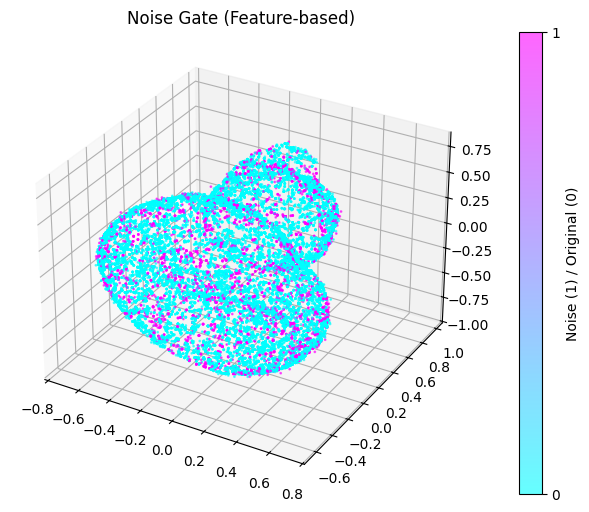

In [12]:
points, true_labels = load_noisy_model("duck", noise_level=1, noise_ratio=15, num_points=30000)

labels, scores, metrics = noise_gate(points, true_labels=true_labels, noise_ratio=0.15)

print("Noise Gate Metrics:", metrics)

plot_results(points, labels, title="Noise Gate (Feature-based)")

In [ ]:
def ensemble_noise_detection(points, true_labels=None,
                             hybrid_params=None, gate_params=None,
                             blend_mode="vote", alpha=0.5, beta=0.5,
                             threshold=0.5, adaptive=False):
  
   
    hybrid_labels, _, _ = hybrid_noise_detection_advanced(points, true_labels, **(hybrid_params or {}))


    gate_labels, _, _ = noise_gate(points, true_labels, **(gate_params or {}))

    if adaptive and blend_mode == "vote":
        #
        spikiness = np.var(points[:, 2])  
        if spikiness > 0.05:
            alpha, beta = 0.4, 0.6
        else:
            alpha, beta = 0.6, 0.4

    if blend_mode == "or":
        final_labels = np.logical_or(hybrid_labels, gate_labels).astype(int)
        scores = final_labels.astype(float)

    elif blend_mode == "and":
        final_labels = np.logical_and(hybrid_labels, gate_labels).astype(int)
        scores = final_labels.astype(float)

    elif blend_mode == "vote":
        total = alpha + beta
        alpha_n, beta_n = alpha / total, beta / total
        scores = alpha_n * hybrid_labels + beta_n * gate_labels
        final_labels = (scores >= threshold).astype(int)

    else:
        raise ValueError("blend_mode must be 'or', 'and', or 'vote'")

  
    metrics = {}
    if true_labels is not None:
        precision = precision_score(true_labels, final_labels, zero_division=0)
        recall = recall_score(true_labels, final_labels, zero_division=0)
        f1s = f1_score(true_labels, final_labels, zero_division=0)
        ari = adjusted_rand_score(true_labels, final_labels)
        metrics = {"precision": precision, "recall": recall, "f1_score": f1s, "ari": ari}

    return final_labels, scores, metrics


def tune_ensemble(points, true_labels, hybrid_params=None, gate_params=None,
                  alpha_grid=[0.2, 0.4, 0.6, 0.8], thresholds=np.linspace(0.3, 0.7, 5)):
    best_f1 = -1
    best_config = None
    best_metrics = None
    best_labels = None

    for alpha in alpha_grid:
        beta = 1 - alpha
        for th in thresholds:
            labels, _, metrics = ensemble_noise_detection(
                points, true_labels,
                hybrid_params=hybrid_params,
                gate_params=gate_params,
                blend_mode="vote", alpha=alpha, beta=beta,
                threshold=th
            )
            if metrics["f1_score"] > best_f1:
                best_f1 = metrics["f1_score"]
                best_config = {"alpha": alpha, "beta": beta, "threshold": th}
                best_metrics = metrics
                best_labels = labels

    return best_labels, best_config, best_metrics


Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_size: 3
Best DBSCAN eps: 0.02, Best HDBSCAN min_cluster_

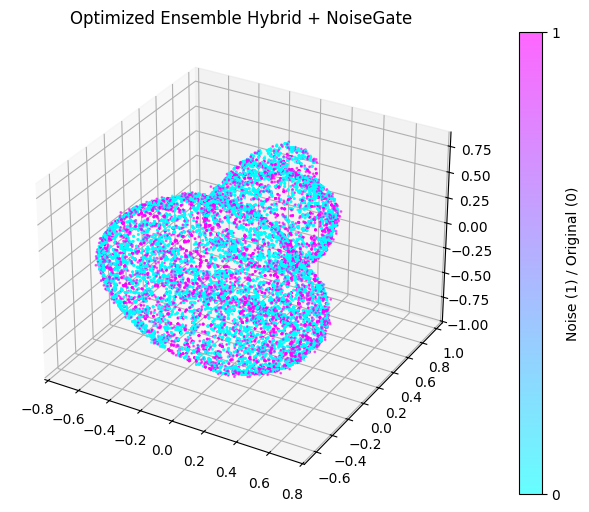

In [18]:
best_labels, best_config, best_metrics = tune_ensemble(
    points, true_labels,
    hybrid_params={"use_pca": True, "eps_values": np.linspace(0.02, 0.1, 10), "hdb_min_sizes": range(2, 10)},
    gate_params={"k": 20, "noise_ratio": 0.15, "weights": (1.0, 2.0, 0.5)}
)

print("Best config:", best_config)
print("Best metrics:", best_metrics)
plot_results(points, best_labels, title="Optimized Ensemble Hybrid + NoiseGate")

